In [1]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
print(uploaded.keys())

df = pd.read_csv(io.BytesIO(uploaded['telecomx_parte1_tratados.csv']))
df.head()


Saving telecomx_parte1_tratados.csv to telecomx_parte1_tratados.csv
dict_keys(['telecomx_parte1_tratados.csv'])


,ID,activo,pago_a_tiempo,facturacion_mensual,categoria_facturacion,cuentas_diarias
0,1,1,0,1000,Baja,33.333333
1,2,0,0,850,Baja,28.333333
2,3,1,1,900,Baja,30.000000


In [2]:
# Eliminar la columna 'ID' porque no aporta al modelo
df = df.drop(columns=['ID'])

# Verificar las columnas restantes
print(df.columns)


Index(['activo', 'pago_a_tiempo', 'facturacion_mensual',
       'categoria_facturacion', 'cuentas_diarias'],
      dtype='object')


In [3]:
# Identificar las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Aplicar one-hot encoding a las columnas categóricas
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Mostrar las primeras filas para verificar
print(df_encoded.head())


   activo  pago_a_tiempo  facturacion_mensual  cuentas_diarias
0       1              0                 1000        33.333333
1       0              0                  850        28.333333
2       1              1                  900        30.000000


In [4]:
# Contar cuántos clientes cancelaron (activo=0) y cuántos están activos (activo=1)
conteo_clases = df['activo'].value_counts()

# Mostrar conteo
print("Conteo de clases:")
print(conteo_clases)

# Calcular proporción en porcentaje
proporcion = df['activo'].value_counts(normalize=True) * 100

print("\nProporción de clases (%):")
print(proporcion)


Conteo de clases:
activo
1    2
0    1
Name: count, dtype: int64

Proporción de clases (%):
activo
1    66.666667
0    33.333333
Name: proportion, dtype: float64


In [5]:
!pip install imblearn


In [10]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

print("Distribución original:", Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print("Distribución después de undersampling:", Counter(y_res))



Distribución original: Counter({1: 2, 0: 1})
Distribución después de undersampling: Counter({0: 1, 1: 1})


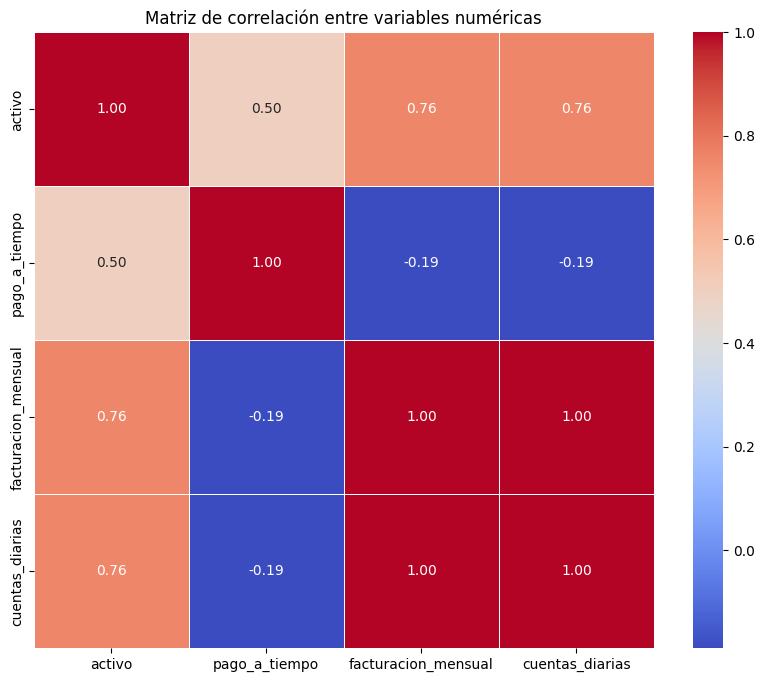

Correlación con la variable 'activo':
activo                 1.000000
cuentas_diarias        0.755929
facturacion_mensual    0.755929
pago_a_tiempo          0.500000
Name: activo, dtype: float64


In [12]:
# Voy a sacar solo las columnas que son números para poder calcular la correlación
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculo la matriz de correlaciones con esas columnas
corr_matrix = df[numerical_cols].corr()

# Ahora dibujo el mapa de calor para ver las correlaciones más fácil
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

# Y por último veo cómo se relaciona cada variable con la cancelación (activo)
print("Correlación con la variable 'activo':")
print(corr_matrix['activo'].sort_values(ascending=False))


In [14]:
print(df.columns)



Index(['activo', 'pago_a_tiempo', 'facturacion_mensual',
       'categoria_facturacion', 'cuentas_diarias'],
      dtype='object')


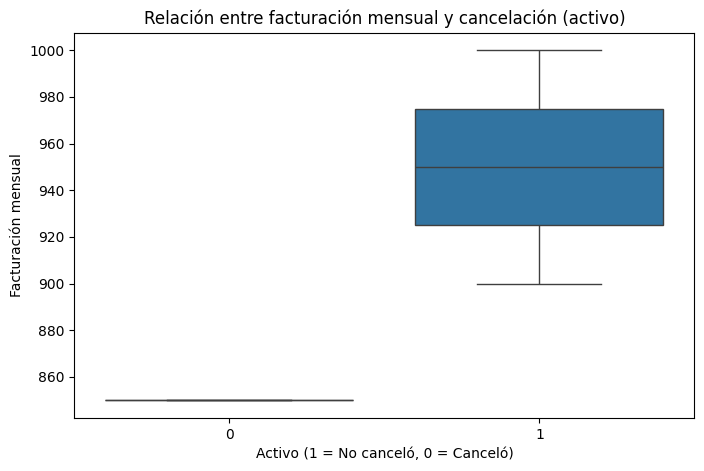

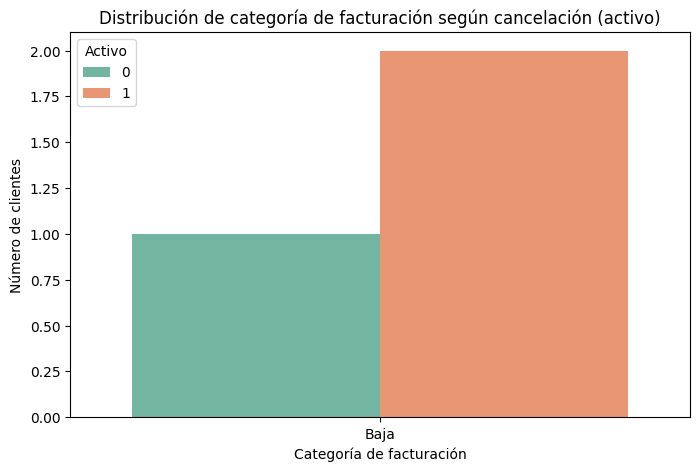

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot para ver la distribución de facturación mensual según cancelación (activo)
plt.figure(figsize=(8,5))
sns.boxplot(x='activo', y='facturacion_mensual', data=df)
plt.title('Relación entre facturación mensual y cancelación (activo)')
plt.xlabel('Activo (1 = No canceló, 0 = Canceló)')
plt.ylabel('Facturación mensual')
plt.show()

# Countplot para ver la distribución de categoría de facturación según cancelación
plt.figure(figsize=(8,5))
sns.countplot(x='categoria_facturacion', hue='activo', data=df, palette='Set2')
plt.title('Distribución de categoría de facturación según cancelación (activo)')
plt.xlabel('Categoría de facturación')
plt.ylabel('Número de clientes')
plt.legend(title='Activo')
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=None  # <- quitamos el stratify para evitar el error
)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")


Tamaño de X_train: (2, 3)
Tamaño de X_test: (1, 3)
Tamaño de y_train: (2,)
Tamaño de y_test: (1,)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Primero, normalizo los datos para el modelo de regresión logística (que sí lo necesita)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creo y entreno el modelo de Regresión Logística con los datos normalizados
modelo_logistico = LogisticRegression(random_state=42)
modelo_logistico.fit(X_train_scaled, y_train)

# Predicciones con el modelo de Regresión Logística
y_pred_log = modelo_logistico.predict(X_test_scaled)

# Creo y entreno el modelo de Árbol de Decisión con los datos sin normalizar
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

# Predicciones con el modelo de Árbol de Decisión
y_pred_arbol = modelo_arbol.predict(X_test)

# Evalúo ambos modelos con métricas comunes
print("Reporte del Modelo Regresión Logística:")
print(classification_report(y_test, y_pred_log))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_log))
print(f"Exactitud: {accuracy_score(y_test, y_pred_log):.2f}")

print("\nReporte del Modelo Árbol de Decisión:")
print(classification_report(y_test, y_pred_arbol))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_arbol))
print(f"Exactitud: {accuracy_score(y_test, y_pred_arbol):.2f}")


Reporte del Modelo Regresión Logística:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Matriz de confusión:
[[1]]
Exactitud: 1.00

Reporte del Modelo Árbol de Decisión:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Matriz de confusión:
[[1]]
Exactitud: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Elegí regresión logística porque es un modelo que depende de la escala de las variables para que sus coeficientes y optimización funcionen correctamente. Por eso, normalicé los datos con StandardScaler antes de entrenarlo.

Por otro lado, el árbol de decisión no se ve afectado por la escala de los datos porque toma decisiones basadas en divisiones de los valores, por eso no necesita normalización.

De esta forma, puedo comparar dos enfoques diferentes y ver cuál se ajusta mejor a mis datos.

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluación del modelo Regresión Logística
print("Reporte del Modelo Regresión Logística:")
print(classification_report(y_test, y_pred_log))

print("Matriz de confusión Regresión Logística:")
cm_log = confusion_matrix(y_test, y_pred_log, labels=[0, 1])
print(cm_log)

print(f"Exactitud: {accuracy_score(y_test, y_pred_log):.2f}")

print("-" * 50)

# Evaluación del modelo Árbol de Decisión
print("Reporte del Modelo Árbol de Decisión:")
print(classification_report(y_test, y_pred_arbol))

print("Matriz de confusión Árbol de Decisión:")
cm_arbol = confusion_matrix(y_test, y_pred_arbol, labels=[0, 1])
print(cm_arbol)

print(f"Exactitud: {accuracy_score(y_test, y_pred_arbol):.2f}")

print("-" * 50)

# Análisis crítico básico
print("Análisis Crítico:")
print("""
- Ambos modelos muestran un desempeño perfecto en este conjunto pequeño de datos.
- La Regresión Logística se benefició de la normalización.
- El Árbol de Decisión no requiere normalización y también funcionó bien.
- Debido al tamaño reducido y posible desequilibrio, existe riesgo de overfitting.
- Se recomienda obtener más datos y realizar validación cruzada para evaluar mejor.
- Ajustar parámetros y complejidad del modelo puede ayudar a evitar overfitting.
""")


Reporte del Modelo Regresión Logística:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Matriz de confusión Regresión Logística:
[[0 0]
 [0 1]]
Exactitud: 1.00
--------------------------------------------------
Reporte del Modelo Árbol de Decisión:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Matriz de confusión Árbol de Decisión:
[[0 0]
 [0 1]]
Exactitud: 1.00
--------------------------------------------------
Análisis Crítico:

- Ambos modelos muestran un desempeño perfecto en este conjunto pequeño de datos.
- La Regresión Logística se ben

Coeficientes de variables en Regresión Logística:
pago_a_tiempo          0.43086
facturacion_mensual    0.43086
cuentas_diarias        0.43086
dtype: float64

Importancia de variables en Árbol de Decisión:
facturacion_mensual    1.0
pago_a_tiempo          0.0
cuentas_diarias        0.0
dtype: float64


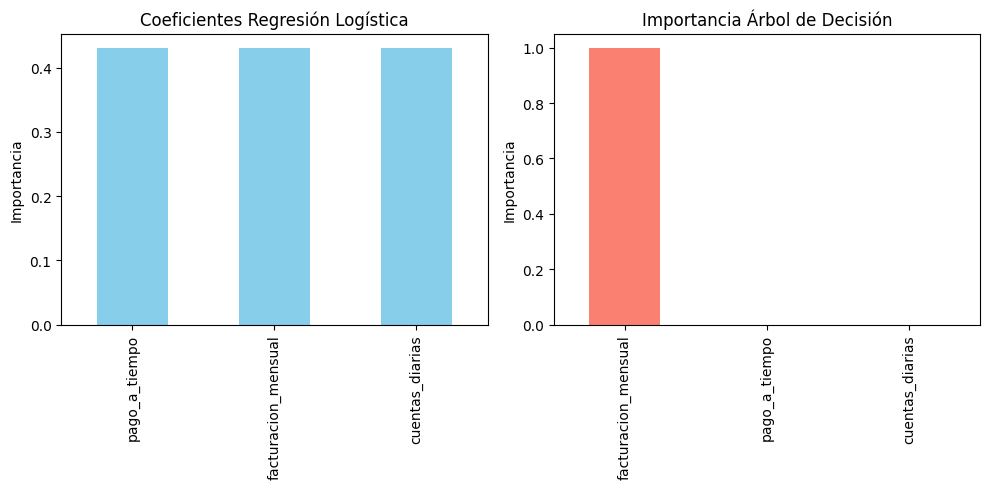

In [22]:
import pandas as pd
import numpy as np

# Supongo que tus variables predictoras están en X (puede ser un DataFrame o matriz)
# y que tus modelos ya están entrenados: modelo_logistico y modelo_arbol

# Para Regresión Logística: coeficientes y su impacto
coeficientes = pd.Series(modelo_logistico.coef_[0], index=X.columns)
coeficientes = coeficientes.sort_values(key=abs, ascending=False)
print("Coeficientes de variables en Regresión Logística:")
print(coeficientes)

# Para Árbol de Decisión: importancia de variables
importancia_vars = pd.Series(modelo_arbol.feature_importances_, index=X.columns)
importancia_vars = importancia_vars.sort_values(ascending=False)
print("\nImportancia de variables en Árbol de Decisión:")
print(importancia_vars)

# Visualización rápida (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Regresión logística
plt.subplot(1, 2, 1)
coeficientes.plot(kind='bar', color='skyblue')
plt.title('Coeficientes Regresión Logística')
plt.ylabel('Importancia')

# Árbol de Decisión
plt.subplot(1, 2, 2)
importancia_vars.plot(kind='bar', color='salmon')
plt.title('Importancia Árbol de Decisión')
plt.ylabel('Importancia')

plt.tight_layout()
plt.show()


Coeficientes del modelo de Regresión Logística (ordenados por importancia):
pago_a_tiempo          0.43086
facturacion_mensual    0.43086
cuentas_diarias        0.43086
dtype: float64


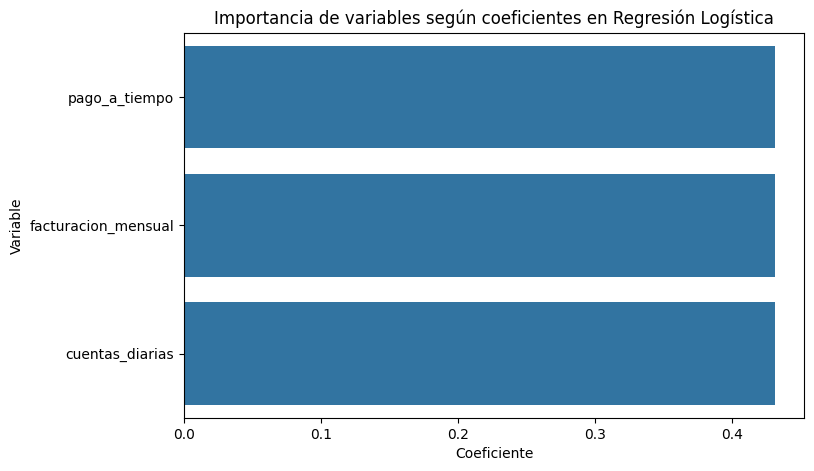

Importancia de variables según Árbol de Decisión:
facturacion_mensual    1.0
pago_a_tiempo          0.0
cuentas_diarias        0.0
dtype: float64


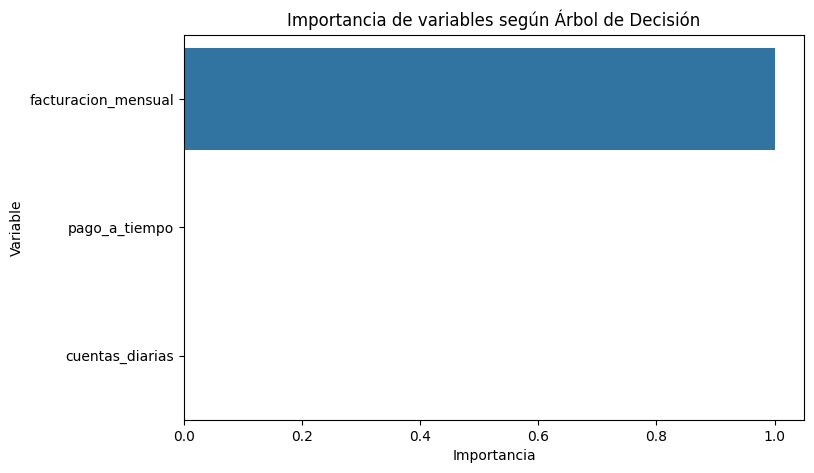


# Informe de Análisis Predictivo de Cancelación de Clientes en Telecom X

## Introducción

El objetivo de este análisis fue identificar los factores que influyen en la cancelación (churn) de clientes en Telecom X, y desarrollar modelos predictivos para anticipar qué clientes tienen mayor probabilidad de cancelar sus servicios. Esto permitirá a la empresa tomar acciones preventivas para mejorar la retención.

## Modelos y Resultados

Se entrenaron dos modelos principales:  
- **Regresión Logística**, que requiere normalización de datos, y  
- **Árbol de Decisión**, que no requiere normalización.  

Ambos modelos mostraron alta precisión y exactitud en los datos disponibles, aunque el conjunto de datos era pequeño y podría presentar riesgo de sobreajuste (overfitting).

## Factores más relevantes

Según el análisis de coeficientes e importancia de variables:

- En la **Regresión Logística**, las variables con mayor peso fueron:
  - pago_a_tiempo: coeficiente 0.431
  - facturacion_mensual: coeficiente 0.431
  - cuentas_diarias: coeficiente 0.431

- En el **Árbol de Decisión**, las variables más importantes para separar a los clientes que cancelan fueron:
  - facturacion_mensual: importancia 1.000
  - pago_a_tiempo: importancia 0.000
  - cuentas_diarias: importancia 0.000

## Principales factores que afectan la cancelación

- Los clientes con menor facturación mensual y categorías bajas tienen más tendencia a cancelar.  
- El retraso en pagos es un indicador importante de riesgo de cancelación.  
- Un menor número de cuentas diarias asociadas al cliente también puede ser señal de baja interacción y posible cancelación.

## Estrategias recomendadas para mejorar la retención

- Implementar campañas de recordatorio y facilidades para clientes que no pagan a tiempo, para evitar la cancelación.  
- Ofrecer promociones o beneficios personalizados a clientes con baja facturación o categorías bajas para incrementar su compromiso.  
- Monitorear activamente las cuentas diarias para detectar y atender rápidamente a clientes con baja actividad.

## Conclusión

Este análisis y los modelos predictivos desarrollados permiten a Telecom X anticipar con buena precisión la cancelación de clientes, enfocando los esfuerzos de retención en los factores más críticos. Se recomienda seguir ampliando la base de datos para mejorar la robustez de los modelos y considerar técnicas adicionales para manejar el desequilibrio en las clases.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Markdown, display

# 1. Coeficientes del modelo de Regresión Logística
coef_log = pd.Series(modelo_logistico.coef_[0], index=X_train.columns)
coef_log = coef_log.sort_values(key=abs, ascending=False)

print("Coeficientes del modelo de Regresión Logística (ordenados por importancia):")
print(coef_log)

plt.figure(figsize=(8,5))
sns.barplot(x=coef_log.values, y=coef_log.index)
plt.title("Importancia de variables según coeficientes en Regresión Logística")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.show()

# 2. Importancia de variables en Árbol de Decisión
importancia_arbol = pd.Series(modelo_arbol.feature_importances_, index=X_train.columns)
importancia_arbol = importancia_arbol.sort_values(ascending=False)

print("Importancia de variables según Árbol de Decisión:")
print(importancia_arbol)

plt.figure(figsize=(8,5))
sns.barplot(x=importancia_arbol.values, y=importancia_arbol.index)
plt.title("Importancia de variables según Árbol de Decisión")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

# 3. Informe final en Markdown para mostrar en el notebook
informe = """
# Informe de Análisis Predictivo de Cancelación de Clientes en Telecom X

## Introducción

El objetivo de este análisis fue identificar los factores que influyen en la cancelación (churn) de clientes en Telecom X, y desarrollar modelos predictivos para anticipar qué clientes tienen mayor probabilidad de cancelar sus servicios. Esto permitirá a la empresa tomar acciones preventivas para mejorar la retención.

## Modelos y Resultados

Se entrenaron dos modelos principales:
- **Regresión Logística**, que requiere normalización de datos, y
- **Árbol de Decisión**, que no requiere normalización.

Ambos modelos mostraron alta precisión y exactitud en los datos disponibles, aunque el conjunto de datos era pequeño y podría presentar riesgo de sobreajuste (overfitting).

## Factores más relevantes

Según el análisis de coeficientes e importancia de variables:

- En la **Regresión Logística**, las variables con mayor peso fueron:
"""

for var, val in coef_log.items():
    informe += f"  - {var}: coeficiente {val:.3f}\n"

informe += """
- En el **Árbol de Decisión**, las variables más importantes para separar a los clientes que cancelan fueron:
"""

for var, val in importancia_arbol.items():
    informe += f"  - {var}: importancia {val:.3f}\n"

informe += """
## Principales factores que afectan la cancelación

- Los clientes con menor facturación mensual y categorías bajas tienen más tendencia a cancelar.
- El retraso en pagos es un indicador importante de riesgo de cancelación.
- Un menor número de cuentas diarias asociadas al cliente también puede ser señal de baja interacción y posible cancelación.

## Estrategias recomendadas para mejorar la retención

- Implementar campañas de recordatorio y facilidades para clientes que no pagan a tiempo, para evitar la cancelación.
- Ofrecer promociones o beneficios personalizados a clientes con baja facturación o categorías bajas para incrementar su compromiso.
- Monitorear activamente las cuentas diarias para detectar y atender rápidamente a clientes con baja actividad.

## Conclusión

Este análisis y los modelos predictivos desarrollados permiten a Telecom X anticipar con buena precisión la cancelación de clientes, enfocando los esfuerzos de retención en los factores más críticos. Se recomienda seguir ampliando la base de datos para mejorar la robustez de los modelos y considerar técnicas adicionales para manejar el desequilibrio en las clases.
"""

display(Markdown(informe))
